# EEG Cleaning and Power Spectral Density Extraction Walkthrough

#### This Jupyter Notebook walks through the steps used to filter noise and identify and remove artifact-heavy segments and extract the power spectral density from scalp EEG. The functions here are the basis of the work in "Quantitative EEG Spectral Features Differentiate Genetic Epilepsies and Predict Neurologic Outcomes" by Galer et al. The file used here is a deidentified EEG from our control cohort from an individual approximetely 12.4 years of age. It has been converted to a fif file to ensure deidentification.

## Import our custom function library

In [43]:
from eeg_core_functions import *


## Read eeg file
### The pipeline typically works with EDF, but to ensure deidentification we use a fif file here

In [78]:
file_path = "/Users/galerp/Documents/manuscripts/QEEG/EEG_Python/"
fif_file = "P591_2017_07_15.fif"

raw = mne.io.read_raw_fif(file_path+fif_file, preload=True)

# Load the data
raw.load_data()


Opening raw data file /Users/galerp/Documents/manuscripts/QEEG/EEG_Python/P591_2017_07_15.fif...
Isotrak not found
    Range : 0 ... 325631 =      0.000 ...  1271.996 secs
Ready.
Reading 0 ... 325631  =      0.000 ...  1271.996 secs...


/var/folders/68/xq3b5xys67b_hlrf8c38lkwcs3pwdc/T/ipykernel_35500/509771734.py:4: RuntimeWarning: This filename (/Users/galerp/Documents/manuscripts/QEEG/EEG_Python/P591_2017_07_15.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path+fif_file, preload=True)


<Raw | P591_2017_07_15.fif, 50 x 325632 (1272.0 s), ~124.3 MB, data loaded>

## Check length of EEG and crop if over limit
### Most standard outpatient EEG in our cohorts are 20-40 minutes in length

In [45]:
#  Maximum duration in seconds (4 hours)
max_duration = 4 * 3600 + 0.1

# Get the duration of the recording
recording_duration = raw.times[-1]

print("Recording duration: ", recording_duration/60 , " minutes")

# Crop the recording if it is longer than 4 hours
if recording_duration > max_duration:
    print("Recording duration is longer than 4 hours. Cropping the recording.")
    raw.crop(tmax=max_duration)

Recording duration:  21.199934895833334  minutes


## 

## Check sampling frequency
### Most standard outpatient EEG in our cohorts are 256Hz. The lowest in the cohort is 200Hz, so all EEGs are downsampled to 200Hz.

In [46]:
# Target sampling frequency
target_sf = 200
# Get the sampling frequency of the data
sf = raw.info['sfreq']

if sf != target_sf:
    print("Resampling the data to ", target_sf, " Hz.")
    if sf > target_sf:
        # Apply notch filter to remove power line noise and its harmonics
        notch_harmonics = generate_harmonics(60, sf)
        rawraw = raw.copy().notch_filter(freqs=notch_harmonics)

        # Apply a low-pass filter to prevent aliasing
        # Define the low-pass filter cutoff as just below half the target sampling frequency (Nyquist frequency)
        low_pass = target_sf / 2 - 5  # 95 Hz if target is 200 Hz

        # Apply a low-pass filter to prevent aliasing
        rawraw.filter(l_freq=None, h_freq=low_pass, method='iir')

        # Resample the data to the target sampling frequency
        rawraw.resample(sfreq=target_sf)
else:
    # Apply notch filter to remove power line noise and its harmonics
    notch_harmonics = generate_harmonics(60, sf)
    rawraw = raw.copy().notch_filter(freqs=notch_harmonics)

# Set the new sampling frequency
sf = target_sf

Resampling the data to  200  Hz.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 95 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 95.00 Hz: -6.02 dB



[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


## Convert to Volts

In [47]:
raw_volts = rawraw.apply_function(lambda x: x * 1e6)

## Check Montage
### In the past few years some EEGs are collected in a slightly higher density Modified Combinatorial Nomenclature (MCN). We need to check to see if this EEG is one of the few in this new format. If so, certain channels need to be renamed back to their original names used in the 10-20 EEG montage system.

In [48]:
# Check if the channel names are the non-standard ones seen in MCN
alt_channels = ['T7', 'T8', 'P7', 'P8']

# Get the channel names
ch_names = raw_volts.info['ch_names']

# T3 is now T7, T4 is now T8, T5 is now P7, T6 is now P8
if any(x in ch_names for x in alt_channels):
    print("Renaming channels")
    raw_volts.rename_channels({'T7':'T3', 'T8':'T4', 'P7':'T5', 'P8':'T6'})

## Apply ICA

In [49]:
raw_volts = remove_art_ica(raw_volts)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 95 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 95.00 Hz: -6.02, -6.02 dB

Fitting ICA to data using 22 channels (please be patient, this may take a while)


/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:887: RuntimeWarning: The unit for channel(s) RAT1 has changed from V to NA.
  raw.set_channel_types({channel_name: channel_type})
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:887: RuntimeWarning: The unit for channel(s) RAT2 has changed from V to NA.
  raw.set_channel_types({channel_name: channel_type})
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:887: RuntimeWarning: The unit for channel(s) CHEST has changed from V to NA.
  raw.set_channel_types({channel_name: channel_type})
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:887: RuntimeWarning: The unit for channel(s) ABD has changed from V to NA.
  raw.set_channel_types({channel_name: channel_type})
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:887: RuntimeWarning: The unit for channel(s) FLOW has changed from V to NA.
  raw.set_channel_types({channel_name: chann

Selecting by number: 20 components
Fitting ICA took 4.5s.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:897: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:897: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method="iclabel")
/Volumes/helbig_lab/Users/galerp/EEG/function_lib/eeg_core_functions.py:897: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA dec

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 4 ICA components
    Projecting back using 22 PCA components


## Take channels needed for quantitative analysis
### We no longer need the channels used in the ICA function such as the ECG or EMG channels.

In [50]:
# Channels to keep
sub_ch = ['C3', 'C4', 'O1', 'O2', 'A1', 'A2', 'Cz', 'F3', 'F4', 'F7', 'F8',
'Fz', 'Fp1', 'Fp2', 'P3', 'P4', 'Pz', 'T3', 'T4', 'T5', 'T6']

# Pick channels
raw_sub= raw_volts.copy().pick_channels(sub_ch)

# Get channels and their indices for dictionary creation
sub_ch_names = raw_sub.info['ch_names']
ch_dict = {i:ch for ch, i in enumerate(sub_ch_names)}

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


## Load data into numpy array, apply bandpass filter, and apply montage

In [51]:
# Load data into numpy array
raw_np = raw_sub.copy().get_data()

# Apply band-pass filter
order = 2
low_cutoff = 0.5
high_cutoff = 70
b,a  = create_band_pass_filter(order,  low_cutoff, high_cutoff, sf) 
filt_data = apply_filter(raw_np, [b,a])

# Apply Laplacian filter
raw_lap = np.apply_along_axis(laplac, 0, filt_data, ch_dict)

# Remove artifact-heavy segments of data

## Set epoch variables

In [52]:
# Final epoch length (seconds)
winLen = 4
# Window size for the sliding window (seconds) - we use no overlap
winDisp_filt = 1
# Window size for artifact segment removal (seconds)
winLen_filt = 1

# Number of data points in each window
bin_n = winLen_filt * sf
# Scan duration in seconds
scan_durn = rawraw._data.shape[1] / sf
# Number of windows in the scan
num_wins = math.floor((rawraw._data.shape[1]-1) / bin_n)


## Identify epochs with excess noise
### The function rejects epochs based on the RMS amplitude, the line length, and amplitude of the signal. It is based off of that as described in Saby et al. 2022 (https://doi.org/10.1093/braincomms/fcac197)

In [53]:
# Remove A1 and A2 channels for epoch rejection
rm_elects = [ch_dict['A1'],ch_dict['A2']]
raw_lap_sub = np.delete(raw_lap, rm_elects, axis=0)
# Get clean epochs
inlier_epoch = epoch_rejection_saby(raw_lap_sub, sf, winDisp_filt, winLen_filt)

# Main data in 1 second time bins
epoch_ch_1sec = moving_window(raw_lap, sf, winDisp_filt, winLen_filt, num_wins)

In [54]:
print("Number of clean epochs: ", len(inlier_epoch))

Number of clean epochs:  1157


## Event detection
### Our custom detection method of annotations of sleep, seizures, photic stimulation, and hyperventilation only functions with an EDF file. To ensure example data is deidentified, it is in a fif file format, thus our function does not work with the provided data.

In [55]:
# Remove events
# inlier_epoch_filt = remove_events(edf_file, inlier_epoch)

# For this example, we will not remove events
inlier_epoch_filt = inlier_epoch

## Combine clean sequences into 4 second epochs and place into numpy array

In [56]:
# Extract clean sequences
sequences = extract_sequences(inlier_epoch_filt, winLen)
epoch_starts = [i[0] for i in sequences]

# Place sequences in numpy array
epoch_ch = np.array([np.concatenate(epoch_ch_1sec[epochs], axis=1) for epochs in sequences])

## Create dataframes for welch output

In [57]:
# Variable for example case
Gene = "Control"
cur_pat = "P591"
scandate = "2017_07_15"

In [58]:
# Dataframe for power and frequency
col_names = ['patient', 'date', 'gene', 'frequency', 'power', 'electrode', 'epochs']
rows = len(sub_ch_names) * 70 #257 is the number of frequencies in the welch output
pat_eo = pd.DataFrame(index = range(rows), columns = col_names)
pat_eo.set_axis(col_names, axis = 1, inplace = True)
pat_eo['patient'] = cur_pat
pat_eo['gene'] = Gene
pat_eo['date'] = scandate
pat_eo['epochs'] = len(epoch_starts)

# Dataframe for epoch information
col_names = ['patient', 'date', 'gene', 'n_epochs', 'epochs', 'amp_filt']
pat_epochs = pd.DataFrame(index = range(1), columns = col_names)
pat_epochs['patient'] = cur_pat
pat_epochs['gene'] = Gene
pat_epochs['date'] = scandate
pat_epochs['n_epochs'] = len(epoch_starts)
pat_epochs['epochs'] = ';'.join(str(i) for i in epoch_starts)
pat_epochs['amp_filt'] = 500

/var/folders/68/xq3b5xys67b_hlrf8c38lkwcs3pwdc/T/ipykernel_35500/3289662499.py:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  pat_eo.set_axis(col_names, axis = 1, inplace = True)


In [59]:
#Calculate dominant frequency in each channel and the corresponding peak value
for ep in range(epoch_ch.shape[1]):
    s_index = ep*70 #70 is the number of frequencies in the welch output
    e_index = s_index + 69
    cur_ch = sub_ch_names[ep]
    pat_eo.loc[s_index:e_index, 'electrode'] = cur_ch
    ch_idx = ch_dict[cur_ch]
    ch_np = epoch_ch[:,ch_idx,:]
    frequencies, med_psd = calculate_median_psd(ch_np, sf)
    mask = np.logical_and(frequencies >= 1, frequencies <= 70)
    pxx = med_psd[mask[0:len(med_psd)]]
    frequencies = frequencies[mask]
    pat_eo.loc[s_index:e_index, 'frequency'] = frequencies
    pat_eo.loc[s_index:e_index, 'power'] = pxx

In [60]:
pat_eo.head()

,patient,date,gene,frequency,power,electrode,epochs
0,P591,2017_07_15,Control,1.0,6.260665,C3,276
1,P591,2017_07_15,Control,2.0,4.794379,C3,276
2,P591,2017_07_15,Control,3.0,2.836894,C3,276
3,P591,2017_07_15,Control,4.0,1.929595,C3,276
4,P591,2017_07_15,Control,5.0,1.635467,C3,276


In [61]:
pat_epochs.head()

,patient,date,gene,n_epochs,epochs,amp_filt
0,P591,2017_07_15,Control,276,7;11;15;30;34;43;47;51;55;59;63;67;71;75;79;83...,500


In [63]:
pat_eo.to_csv("/Users/galerp/Documents/manuscripts/QEEG/EEG_Python/control_pat_psd_test.csv", index=False)
pat_epochs.to_csv("/Users/galerp/Documents/manuscripts/QEEG/EEG_Python/pat_epochs_test.csv", index=False)



# Plotting example
#### Here we can view the power spectral density in the occipital electrodes. You should be able to see a clear posterior dominant rhythm in the alpha band.

In [76]:
# Need plotting library
import matplotlib.pyplot as plt


In [74]:
# Extract just the occipital electrodes
occ_data = pat_eo[pat_eo['electrode'].isin(['O1', 'O2'])]
# Ensure power is numeric
occ_data['power'] = pd.to_numeric(occ_data['power'], errors='coerce')  # Convert to numeric and coerce errors
occ_data['log_power'] = np.log(occ_data['power'])


/var/folders/68/xq3b5xys67b_hlrf8c38lkwcs3pwdc/T/ipykernel_35500/2934496347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_data['power'] = pd.to_numeric(occ_data['power'], errors='coerce')  # Convert to numeric and coerce errors
/var/folders/68/xq3b5xys67b_hlrf8c38lkwcs3pwdc/T/ipykernel_35500/2934496347.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occ_data['log_power'] = np.log(occ_data['power'])


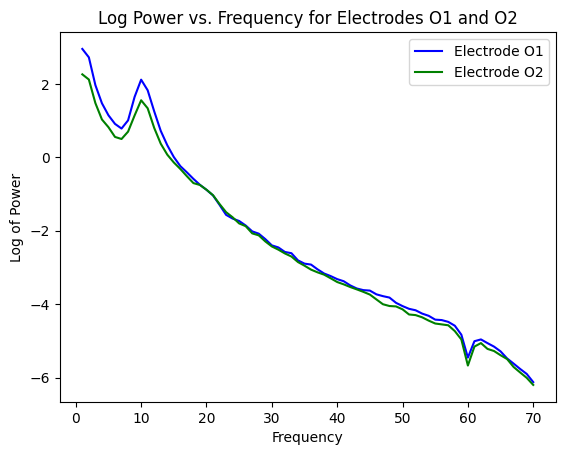

In [75]:
fig, ax = plt.subplots()

# Filter and plot each electrode separately to assign different colors
for electrode, color in zip(['O1', 'O2'], ['blue', 'green']):
    subset = occ_data[occ_data['electrode'] == electrode]
    ax.plot(subset['frequency'], subset['log_power'], label=f'Electrode {electrode}', color=color)

ax.set_xlabel('Frequency')
ax.set_ylabel('Log of Power')
ax.set_title('Log Power vs. Frequency for Electrodes O1 and O2')
ax.legend()

plt.show()